In [1]:
!pip install ultralytics roboflow opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 99.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [6]:

# Model Loading Cell
import torch
from ultralytics import YOLO

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# UPDATE THESE PATHS TO YOUR MODEL LOCATIONS
HUMAN_MODEL_PATH = '/content/drive/MyDrive/Research/human detection/best (1).pt'
PPE_MODEL_PATH = '/content/drive/MyDrive/Research/ppe_detection_model/best.pt'

try:
    human_model = YOLO(HUMAN_MODEL_PATH)
    human_model.to(device)
    print(f" Human detection model loaded from: {HUMAN_MODEL_PATH}")
except Exception as e:
    print(f" Error loading human model: {e}")
    raise

try:
    ppe_model = YOLO(PPE_MODEL_PATH)
    ppe_model.to(device)
    print(f" PPE detection model loaded from: {PPE_MODEL_PATH}")
except Exception as e:
    print(f" Error loading PPE model: {e}")
    raise

# Define mandatory PPE items
MANDATORY_PPE = ["helmet", "vest", "boots"]
print(f"Mandatory PPE items: {', '.join(MANDATORY_PPE)}")


Using device: cuda
GPU: Tesla T4
 Human detection model loaded from: /content/drive/MyDrive/Research/human detection/best (1).pt
 PPE detection model loaded from: /content/drive/MyDrive/Research/ppe_detection_model/best.pt
Mandatory PPE items: helmet, vest, boots


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Core Processing Functions
import cv2
import numpy as np

def detect_ppe_for_person(human_roi, ppe_model, mandatory_ppe):
    """Detect PPE items for a single person"""
    if human_roi.size == 0:
        return set(), []

    ppe_results = ppe_model.predict(source=human_roi, save=False, verbose=False)
    detected_ppe = set()
    ppe_boxes = []

    if len(ppe_results[0].boxes) > 0:
        for box, cls, conf in zip(
            ppe_results[0].boxes.xyxy,
            ppe_results[0].boxes.cls,
            ppe_results[0].boxes.conf
        ):
            ppe_class = ppe_results[0].names[int(cls)].lower()
            detected_ppe.add(ppe_class)
            ppe_boxes.append((box.tolist(), ppe_class, conf.item()))

    return detected_ppe, ppe_boxes


def process_image(image, human_model, ppe_model, mandatory_ppe,
                 show_ppe_boxes=False, conf_threshold=0.5):
    """Process a single image for PPE detection"""
    if image is None or image.size == 0:
        raise ValueError("Invalid image provided")

    result_image = image.copy()
    stats = {
        'total_persons': 0,
        'safe_persons': 0,
        'unsafe_persons': 0,
        'detections': []
    }

    # Detect humans
    human_results = human_model.predict(
        source=image,
        save=False,
        verbose=False,
        conf=conf_threshold
    )

    if len(human_results[0].boxes) == 0:
        return result_image, stats

    stats['total_persons'] = len(human_results[0].boxes)

    # Process each detected person
    for idx, (human_box, human_conf) in enumerate(zip(
        human_results[0].boxes.xyxy,
        human_results[0].boxes.conf
    )):
        x1, y1, x2, y2 = map(int, human_box.tolist())

        # Add padding to capture PPE items near person
        padding = 20
        x1_pad = max(0, x1 - padding)
        y1_pad = max(0, y1 - padding)
        x2_pad = min(image.shape[1], x2 + padding)
        y2_pad = min(image.shape[0], y2 + padding)

        # Crop human region
        human_roi = image[y1_pad:y2_pad, x1_pad:x2_pad]

        # Detect PPE for this person
        detected_ppe, ppe_boxes = detect_ppe_for_person(
            human_roi, ppe_model, mandatory_ppe
        )

        # Determine safety status
        missing_ppe = [item for item in mandatory_ppe if item not in detected_ppe]
        is_safe = len(missing_ppe) == 0

        if is_safe:
            status = "Safe"
            color = (0, 255, 0)
            stats['safe_persons'] += 1
        else:
            status = f"Unsafe (Missing: {', '.join(missing_ppe)})"
            color = (0, 0, 255)
            stats['unsafe_persons'] += 1

        # Store detection info
        stats['detections'].append({
            'person_id': idx + 1,
            'status': 'safe' if is_safe else 'unsafe',
            'detected_ppe': list(detected_ppe),
            'missing_ppe': missing_ppe,
            'confidence': round(human_conf.item(), 2)
        })

        # Draw bounding box for person
        cv2.rectangle(result_image, (x1, y1), (x2, y2), color, 3)

        # Add label with person number and status
        label = f"Person {idx + 1}: {status}"
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]

        # Draw label background
        cv2.rectangle(
            result_image,
            (x1, y1 - label_size[1] - 10),
            (x1 + label_size[0], y1),
            color,
            -1
        )
        cv2.putText(
            result_image, label, (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2
        )


    # Add summary text
    summary = f"Total: {stats['total_persons']} | Safe: {stats['safe_persons']} | Unsafe: {stats['unsafe_persons']}"
    cv2.putText(
        result_image, summary, (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2
    )
    cv2.putText(
        result_image, summary, (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1
    )

    return result_image, stats

print("✓ Core functions loaded successfully!")

✓ Core functions loaded successfully!


Processing image: /content/drive/MyDrive/Research/Test /images/image12.jpeg
Image size: 960x1280

DETECTION RESULTS
Total persons detected: 2
Safe: 1
Unsafe: 1

Detailed breakdown:

Person 1:
  Status: UNSAFE
  Detected Classes: no helmet, vest, no boots
  Missing PPE: helmet, boots
  Confidence: 0.88

Person 2:
  Status: SAFE
  Detected Classes: helmet, vest, boots
  Confidence: 0.86

 Result saved to: output_image_result.jpg

Displaying result:


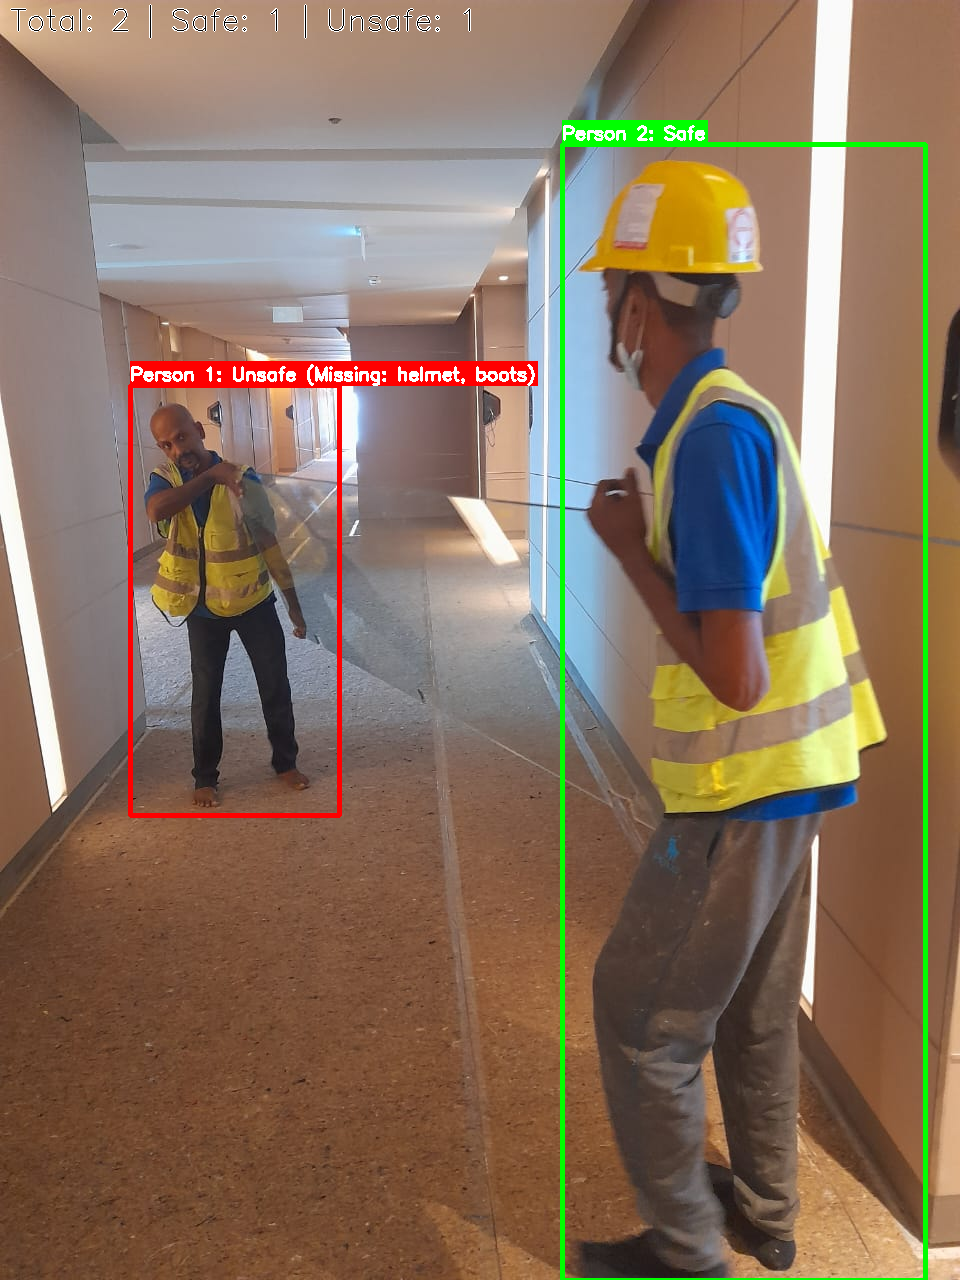

In [12]:
# Test with Image
from google.colab.patches import cv2_imshow

# UPDATE THIS PATH TO YOUR TEST IMAGE
TEST_IMAGE_PATH = '/content/drive/MyDrive/Research/Test /images/image12.jpeg'

try:
    image = cv2.imread(TEST_IMAGE_PATH)

    if image is None:
        raise ValueError(f"Could not load image from {TEST_IMAGE_PATH}")

    print(f"Processing image: {TEST_IMAGE_PATH}")
    print(f"Image size: {image.shape[1]}x{image.shape[0]}")

    # Process with PPE boxes visible
    processed_image, stats = process_image(
        image=image,
        human_model=human_model,
        ppe_model=ppe_model,
        mandatory_ppe=MANDATORY_PPE,
        show_ppe_boxes=True,
        conf_threshold=0.5
    )

    # Display results
    print("\n" + "="*50)
    print("DETECTION RESULTS")
    print("="*50)
    print(f"Total persons detected: {stats['total_persons']}")
    print(f"Safe: {stats['safe_persons']}")
    print(f"Unsafe: {stats['unsafe_persons']}")
    print("\nDetailed breakdown:")

    for detection in stats['detections']:
        print(f"\nPerson {detection['person_id']}:")
        print(f"  Status: {detection['status'].upper()}")
        print(f"  Detected Classes: {', '.join(detection['detected_ppe']) if detection['detected_ppe'] else 'None'}")
        if detection['missing_ppe']:
            print(f"  Missing PPE: {', '.join(detection['missing_ppe'])}")
        print(f"  Confidence: {detection['confidence']}")

    # Save result
    output_path = 'output_image_result.jpg'
    cv2.imwrite(output_path, processed_image)
    print(f"\n Result saved to: {output_path}")

    # Display
    print("\nDisplaying result:")
    cv2_imshow(processed_image)

except Exception as e:
    print(f" Error processing image: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# Real-time Video Processing Functions
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
import time

def process_video_realtime_display(video_path, human_model, ppe_model, mandatory_ppe,
                                   show_ppe_boxes=False, save_output=True,
                                   output_path='output_realtime.mp4'):
    """Process video and display frames in real-time"""
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Video writer
    out = None
    if save_output:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Create display widgets
    display_widget = widgets.Image(format='jpeg', width=800)
    progress_widget = widgets.IntProgress(
        value=0, min=0, max=total_frames,
        description='Progress:',
        bar_style='info',
        style={'bar_color': '#00ff00'},
        orientation='horizontal'
    )
    status_widget = widgets.HTML(value="<b>Starting video processing...</b>")

    # Display widgets
    display(widgets.VBox([status_widget, progress_widget, display_widget]))

    frame_count = 0
    overall_stats = {
        'total_frames': total_frames,
        'processed_frames': 0,
        'total_safe_detections': 0,
        'total_unsafe_detections': 0
    }

    start_time = time.time()

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # Process frame
            processed_frame, stats = process_image(
                frame, human_model, ppe_model, mandatory_ppe,
                show_ppe_boxes, conf_threshold=0.5
            )

            # Update stats
            overall_stats['processed_frames'] = frame_count
            overall_stats['total_safe_detections'] += stats['safe_persons']
            overall_stats['total_unsafe_detections'] += stats['unsafe_persons']

            # Save frame
            if save_output and out is not None:
                out.write(processed_frame)

            # Update display
            _, buffer = cv2.imencode('.jpg', processed_frame)
            display_widget.value = buffer.tobytes()

            # Update progress
            progress_widget.value = frame_count

            # Calculate stats
            elapsed = time.time() - start_time
            fps_current = frame_count / elapsed if elapsed > 0 else 0
            eta = (total_frames - frame_count) / fps_current if fps_current > 0 else 0

            # Update status
            status_html = f"""
            <div style='font-family: monospace; background-color: #f0f0f0; padding: 10px; border-radius: 5px;'>
                <b>Frame:</b> {frame_count}/{total_frames} |
                <b>FPS:</b> {fps_current:.1f} |
                <b>ETA:</b> {eta:.0f}s<br>
                <b>Current Frame:</b>
                <span style='color: green;'>✓ Safe: {stats['safe_persons']}</span> |
                <span style='color: red;'>⚠ Unsafe: {stats['unsafe_persons']}</span><br>
                <b>Total:</b>
                <span style='color: green;'>Safe: {overall_stats['total_safe_detections']}</span> |
                <span style='color: red;'>Unsafe: {overall_stats['total_unsafe_detections']}</span>
            </div>
            """
            status_widget.value = status_html

    finally:
        cap.release()
        if out is not None:
            out.release()

        # Final summary
        elapsed_total = time.time() - start_time
        avg_fps = frame_count / elapsed_total if elapsed_total > 0 else 0

        final_status = f"""
        <div style='font-family: monospace; background-color: #d4edda; padding: 15px; border-radius: 5px; border: 2px solid #28a745;'>
            <h3 style='color: #155724; margin-top: 0;'>✓ Processing Complete!</h3>
            <b>Total Frames:</b> {frame_count}<br>
            <b>Processing Time:</b> {elapsed_total:.1f}s<br>
            <b>Average FPS:</b> {avg_fps:.1f}<br>
            <b>Total Safe Detections:</b> <span style='color: green;'>{overall_stats['total_safe_detections']}</span><br>
            <b>Total Unsafe Detections:</b> <span style='color: red;'>{overall_stats['total_unsafe_detections']}</span><br>
            {f"<b>Output saved to:</b> {output_path}" if save_output else ""}
        </div>
        """
        status_widget.value = final_status
        progress_widget.bar_style = 'success'

    return output_path if save_output else None, overall_stats

print(" Real-time video functions loaded!")

✓ Real-time video functions loaded!


In [ ]:
# Process video with real-time display

# UPDATE THIS PATH TO YOUR VIDEO
TEST_VIDEO_PATH = '/content/drive/MyDrive/Research/Test /vedios/vedio2.mp4'

output_path, stats = process_video_realtime_display(
    video_path=TEST_VIDEO_PATH,
    human_model=human_model,
    ppe_model=ppe_model,
    mandatory_ppe=MANDATORY_PPE,

    save_output=True,
    output_path='/content/output_realtime.mp4'
)

print("\n Video processing complete!")
print(f"Output saved to: {output_path}")


✓ Video processing complete!
Output saved to: /content/output_realtime.mp4
